In [157]:
!jupyter nbconvert --to slides presentatie.ipynb --SlidesExporter.reveal_transition=none --TemplateExporter.exclude_input=True

[NbConvertApp] Converting notebook presentatie.ipynb to slides
[NbConvertApp] Writing 766199 bytes to presentatie.slides.html


# TEAM WATER
<img src="logo.jpg" style="width: 400px;"/>
Valerie Demetriades,
Thomas Deurloo &
Simon Nouwens (that's me!)

# PROBLEM STATEMENT
Current policy: brute force
- wasted water; __brabant water__
- expensive (70 million nationally nursing homes); __housing cooperations, governmental organisations, health care organisations__
- not effective (there are still plenty of legionella cases); __ministry of public health__

# THE FUTURE
With the decision support system decisions on flushing can be made on risk assesment.

<img src="icons.png"/>

# ANALYSIS
 
 
<img src="legionella.png"/>

# ANALYSIS
The residence time is determined by the flow in the system, during extensive periods of none flushing risks increase, for example when somebody is on a vacation.

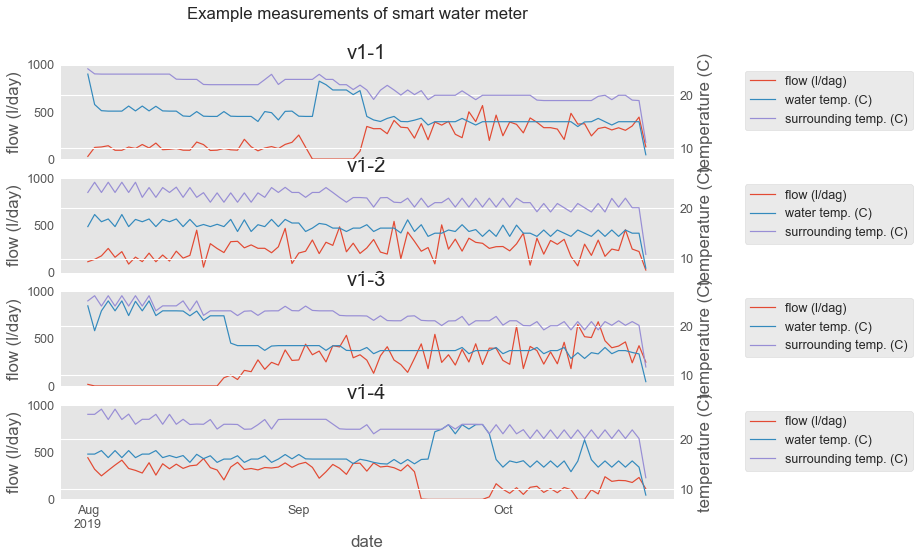

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
df = pd.read_csv('../data/Temperatuur_Flow.csv')
df.set_index(pd.to_datetime(df['uitleestijdstip']), inplace=True)
df['volume (l)'] = (df['volume 1'] - df['volume 1'].shift(1))*1000
apps = df['v-app'].unique()

df = df.groupby([pd.Grouper(freq='1D'), 'v-app']).sum().unstack('v-app')
df = df['20190801':]

fig, ax = plt.subplots(nrows=4, figsize=(11, 8))

for idx, app in enumerate(apps[:4]):
    df['volume (l)'][app].plot(ax=ax[idx], ylim=(0,1000), title=app, label='flow (l/dag)', legend=True)
    (df['gelogde min. mediumtemp.'][app]/24).plot(ax=ax[idx], secondary_y=True, label='water temp. (C)', legend=True)
    (df['gelogde gemiddelde omgevingstemp.'][app]/24).plot(ax=ax[idx], secondary_y=True, label='surrounding temp. (C)', legend=True)
    ax[idx].set_ylabel('flow (l/day)')
    plt.ylabel('temperature (C)')
    ax[idx].set_xlabel('date')
    h1, l1 = ax[idx].get_legend_handles_labels()
    h2, l2 = ax[idx].right_ax.get_legend_handles_labels()
    ax[idx].legend(h1+h2, l1+l2, loc=1, bbox_to_anchor=[1.4,1])
fig.suptitle('Example measurements of smart water meter');

In [12]:
df = pd.read_csv('../data/Temperatuur_Flow.csv')
df['uitleestijdstip'] = pd.to_datetime(df['uitleestijdstip'])
df = df.sort_values(['v-app','uitleestijdstip'])
df.set_index('uitleestijdstip', inplace=True)
df['vol'] = df['volume 1']
df['target'] = df['delta (omg-med)']
df['water_temp'] = df['gelogde min. mediumtemp.']
df['inx'] = df['Unnamed: 0']

current_app = False
current_volume = 0

running_hours = 0
data = []
for inx, row in df.iloc[:].iterrows():
    print(row['inx'], end='\r')
    if row['v-app'] != current_app:
        current_app = row['v-app']
        current_volume = row['vol']
        running_hours = 0
        continue
    if row['vol'] != current_volume:
        current_volume = row['vol']
        running_hours = 0
        continue
    data.append({'hour': running_hours, 
                 'target': row.target, 
                 'water_temp': row.water_temp,
                 'clock_hour': inx.hour})
    running_hours += 1
    

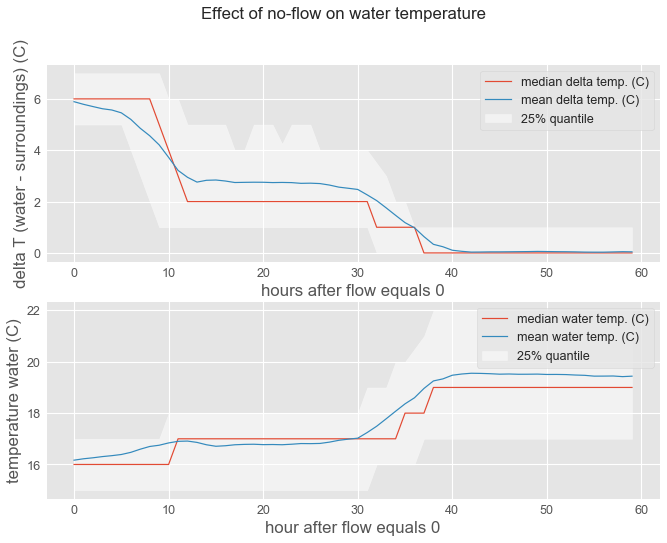

In [147]:
fig, ax = plt.subplots(2,1,figsize=(11,8))

agg = pd.DataFrame(data).groupby('hour').target
agg.median().iloc[:60].plot(label='median delta temp. (C)', legend=True, ax=ax[0])
agg.mean().iloc[:60].plot(label='mean delta temp. (C)', legend=True, ax=ax[0])
lower_bound = agg.quantile(.75).iloc[:60]
upper_bound = agg.quantile(.25).iloc[:60]
ax[0].fill_between(range(60), lower_bound, upper_bound, alpha=0.5, label='25% quantile', color='white')
ax[0].legend()
ax[0].set_xlabel('hours after flow equals 0')
ax[0].set_ylabel('delta T (water - surroundings) (C)');

agg = pd.DataFrame(data).groupby('hour').water_temp
agg.median().iloc[:60].plot(label='median water temp. (C)', legend=True, ax=ax[1])
agg.mean().iloc[:60].plot(label='mean water temp. (C)', legend=True, ax=ax[1])
lower_bound = agg.quantile(.75).iloc[:60]
upper_bound = agg.quantile(.25).iloc[:60]
ax[1].fill_between(range(60), lower_bound, upper_bound, alpha=0.5, label='25% quantile', color='white')
ax[1].legend()
ax[1].set_xlabel('hour after flow equals 0')
ax[1].set_ylabel('temperature water (C)');
fig.suptitle('Effect of no-flow on water temperature');

# ANALYSIS
There are large differences in legionella cases between locations, water points.

All p-values around 0, R2 of 0.11


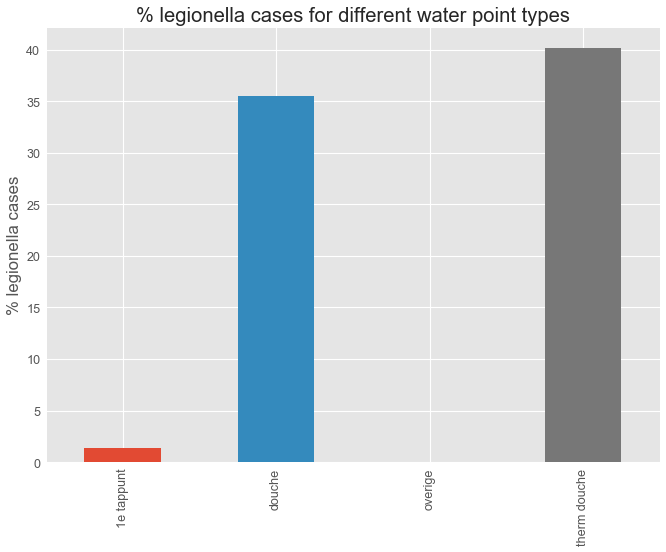

In [148]:
df = pd.read_csv('./../data/Monsteruitslagen_Resultaten.csv')
df['datetime'] = pd.to_datetime(df.datum + ' ' + df.tijd)

def convert_tappunt(x):
    x = str(x).lower()
    if 'thermostatische douchemengkraan' in x or 'therm.' in x:
        return 'therm douche'
    if 'douche' in x:
        return 'douche'
    if '1e tappunt' in x:
        return '1e tappunt'
    return 'overige'

def convert_ruimte(x):
    x = str(x).lower()
    if 'kelder' in x:
        return 'kelder'
    if 'kamer' in x:
        return 'kamer'
    if 'appartement' in x:
        return 'appartement'
    if 'technische ruimte' in x:
        return 'technische ruimte'
    if 'kapsalon' in x:
        return 'overige'
    return 'overige'
    
df['tappunt_simple'] = df.tappunt.apply(convert_tappunt)
df['ruimte_simple'] = df.ruimte.apply(convert_ruimte)
df['location_is_Noorderkroon'] = df.locatienaam.str.contains('Noorderkroon')
df['location_is_Nieuwehagen'] = df.locatienaam.str.contains('Nieuwehagen')

df_tmp = df[df.component == 'Totaal Legionella spp'].copy()
df_tmp.resultaat = df_tmp.resultaat.str.replace('<100', '0').astype(int)
df_tmp.resultaat.groupby(pd.qcut(df_tmp.tempvoor, 4)).describe()

def get_level(x):
    for i in [0,1,2,3,4]:
        if '{}.'.format(i) in x:
            return i
    return -1
    
df_tmp['app_level'] = df_tmp.ruimte.apply(get_level)
target = (df_tmp.resultaat > 0).astype(int)

((df_tmp.resultaat > 0)*100).astype(int).groupby(df_tmp['tappunt_simple']).mean().plot.bar(figsize=(11,8), title='% legionella cases for different water point types')
plt.xlabel('')
plt.ylabel('% legionella cases')
print('All p-values around 0, R2 of 0.11')

All p-values around 0, R2 of 0.14


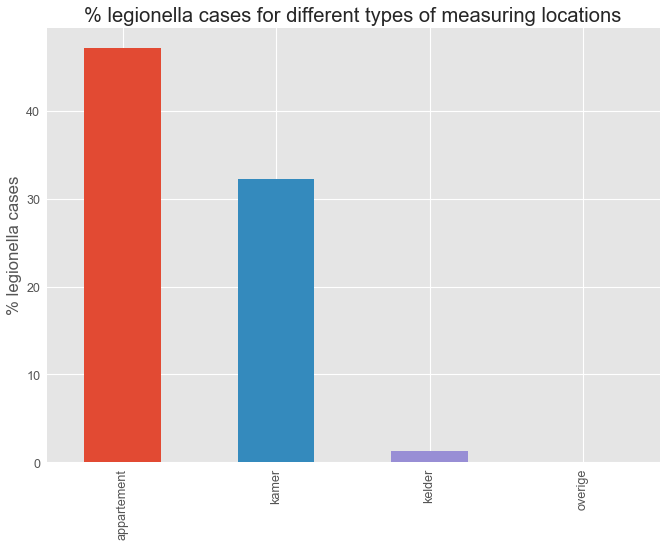

In [149]:
((df_tmp.resultaat > 0)*100).astype(int).groupby(df_tmp['ruimte_simple']).mean().plot.bar(figsize=(11,8), title='% legionella cases for different types of measuring locations')

plt.xlabel('')
plt.ylabel('% legionella cases')
print('All p-values around 0, R2 of 0.14')

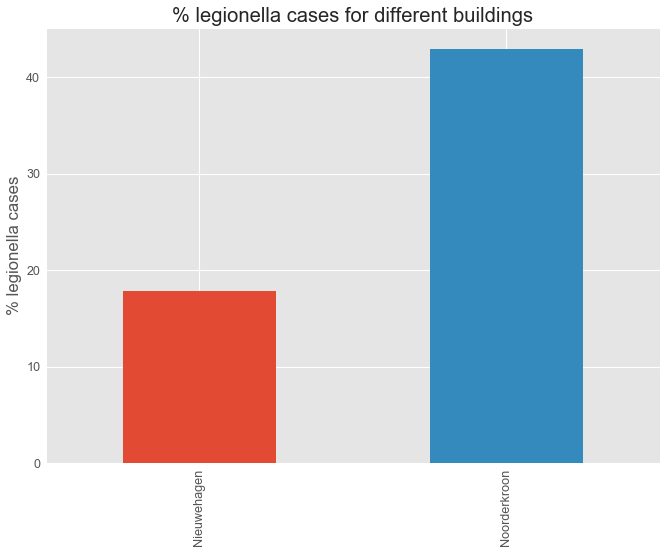

In [150]:
df_tmp['app_level'] = df_tmp.ruimte.apply(get_level)
df_tmp['resultaat_bin'] = (df_tmp.resultaat > 0).astype(int)
(df_tmp['resultaat_bin']*100).groupby(df_tmp.location_is_Noorderkroon).mean().plot.bar(figsize=(11,8))
plt.xlabel('')
plt.ylabel('% legionella cases');
plt.title('% legionella cases for different buildings')
plt.xticks([0,1], ['Nieuwehagen', 'Noorderkroon']);

# MYTHES
Sun/shadow has an effect on legionella cases.

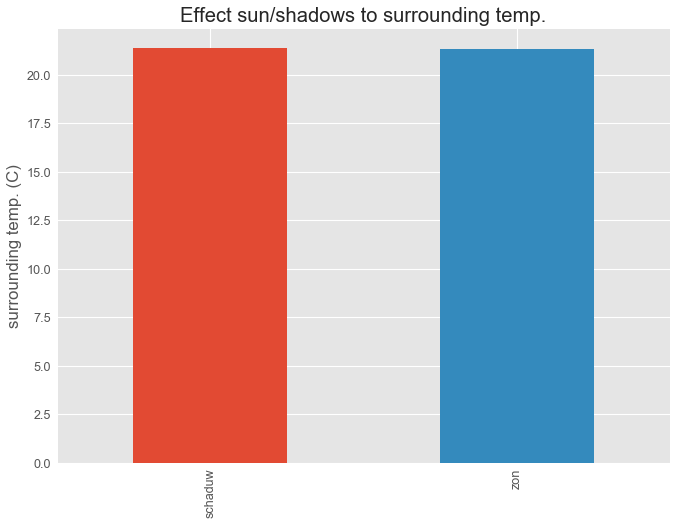

In [151]:
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
import matplotlib.pyplot as plt

df = pd.read_csv('../data/Temperatuur_Flow.csv')
df['uitleestijdstip'] = pd.to_datetime(df['uitleestijdstip'])
df = df.sort_values(['v-app','uitleestijdstip'])
df.set_index('uitleestijdstip', inplace=True)
df['vol'] = df['volume 1']
df['target'] = df['delta (omg-med)']
df['inx'] = df['Unnamed: 0']
(df['gelogde gemiddelde omgevingstemp.']).groupby(df.ligging).mean().plot.bar(title='Effect sun/shadows to surrounding temp.', figsize=(11,8))
plt.xlabel('')
plt.ylabel('surrounding temp. (C)');
plt.show()

dfs = df[df.ligging == 'schaduw']
dfz = df[df.ligging == 'zon']

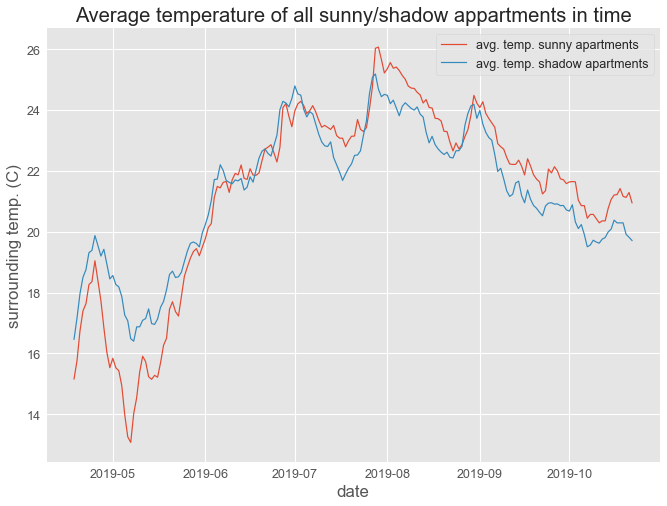

In [152]:
dfs['gelogde gemiddelde omgevingstemp.'].groupby(dfs.index.date).mean().plot(label='avg. temp. sunny apartments', legend=True, figsize=(11,8))
dfz['gelogde gemiddelde omgevingstemp.'].groupby(dfz.index.date).mean().plot(label='avg. temp. shadow apartments', legend=True)
plt.xlabel('date')
plt.title('Average temperature of all sunny/shadow appartments in time')
plt.ylabel('surrounding temp. (C)');

# WHAT DO WE NEED?

<img src="legionulla.png"/>

# WHAT DO WE NEED?


### CHANGE THE LEGISLATION!
- we need proof that the current legislation, SUCKS!
- by measuring we can gather this proof;
- we need a businesscase to show the importance;

In [155]:
from IPython.display import Video

Video("demo.mp4")

# LEGIONULLA LET'S GO!
´LegioNULLA is able to efficiently detect when mains need to be flushed to prevent Legionella bacteria from spreading”